In [47]:
#@title Drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')
Root = "/content/drive/MyDrive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
#@title Librerias
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd


In [49]:
#@title Paths
DATASET_PATH = '/content/drive/MyDrive/Proyecto/Data'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_mfcc=13
n_fft=2048
hop_length=512
num_segments = 10
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [50]:
#@title Diccionario
# dictionary to store mapping, labels, and MFCCs
data = {
    "mapping": [],
    "labels": [],
    "mfcc": []
}
# loop through all genre sub-folder
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):

    # ensure we're processing a genre sub-folder level
    if dirpath is not DATASET_PATH:

        # save genre label (i.e., sub-folder name) in the mapping
        dirpathSplit = dirpath.split("/")
        semantic_label = dirpathSplit[-1]
        if('genres_original' in dirpathSplit and 'jazz' not in dirpathSplit):
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-2)
                        #print("{}, segment:{}".format(file_path, d+1))


Processing: genres_original

Processing: classical

Processing: metal

Processing: pop

Processing: country

Processing: hiphop

Processing: blues

Processing: reggae

Processing: rock

Processing: disco


In [51]:
#@title Función plot
def plot_history_A(history):
    fig, axs = plt.plot(1)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    plt.show()

def plot_history_E(history):
    fig, axs = plt.plot(1)

    # create error sublpot
    axs[0].plot(history.history["loss"], label="train error")
    axs[0].plot(history.history["val_loss"], label="test error")
    axs[0].set_ylabel("Error")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="upper right")
    axs[0].set_title("Error eval")
    plt.show()

In [52]:
#@title Función train_test_split
def prepare_datasets(test_size, validation_size):

    # load data
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [53]:
#@title Modelo
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [54]:
#@title Llamando funciones
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [55]:
#@title Creación del modelo
input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
model = build_model(input_shape)

In [56]:
#@title Summary
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 130, 64)           19968     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [57]:
#@title Time
import time
from tensorflow.keras.callbacks import ModelCheckpoint
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
checkpointer = ModelCheckpoint(filepath=f'Proyecto/models/audio_classification_{current_time}.Rnn', verbose=0, save_best_only=True)

In [58]:
#@title Entrenamiento
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50, callbacks=[checkpointer])

Epoch 1/50
169/169 [==============================] - 29s 153ms/step - loss: 2.2117 - accuracy: 0.1688 - val_loss: 2.0564 - val_accuracy: 0.3489


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 2/50
169/169 [==============================] - 25s 149ms/step - loss: 1.9116 - accuracy: 0.3469 - val_loss: 1.7258 - val_accuracy: 0.4141


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 3/50
169/169 [==============================] - 25s 148ms/step - loss: 1.6891 - accuracy: 0.4067 - val_loss: 1.5582 - val_accuracy: 0.4548


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 4/50
169/169 [==============================] - 25s 149ms/step - loss: 1.5709 - accuracy: 0.4364 - val_loss: 1.4751 - val_accuracy: 0.4704


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 5/50
169/169 [==============================] - 26s 153ms/step - loss: 1.5017 - accuracy: 0.4564 - val_loss: 1.4383 - val_accuracy: 0.4711


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 6/50
169/169 [==============================] - 25s 148ms/step - loss: 1.4400 - accuracy: 0.4749 - val_loss: 1.3971 - val_accuracy: 0.4896


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 7/50
169/169 [==============================] - 25s 149ms/step - loss: 1.3865 - accuracy: 0.4969 - val_loss: 1.3450 - val_accuracy: 0.5030


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 8/50
169/169 [==============================] - 25s 149ms/step - loss: 1.3602 - accuracy: 0.5021 - val_loss: 1.3202 - val_accuracy: 0.5215


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 9/50
169/169 [==============================] - 25s 149ms/step - loss: 1.3005 - accuracy: 0.5255 - val_loss: 1.2793 - val_accuracy: 0.5504


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 10/50
169/169 [==============================] - 25s 148ms/step - loss: 1.2784 - accuracy: 0.5372 - val_loss: 1.2628 - val_accuracy: 0.5563


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 11/50
169/169 [==============================] - 28s 164ms/step - loss: 1.2414 - accuracy: 0.5520 - val_loss: 1.2472 - val_accuracy: 0.5489


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 12/50
169/169 [==============================] - 25s 151ms/step - loss: 1.2208 - accuracy: 0.5579 - val_loss: 1.2247 - val_accuracy: 0.5600


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 13/50
169/169 [==============================] - 25s 150ms/step - loss: 1.1966 - accuracy: 0.5729 - val_loss: 1.2075 - val_accuracy: 0.5748


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 14/50
169/169 [==============================] - 25s 151ms/step - loss: 1.1547 - accuracy: 0.5888 - val_loss: 1.2145 - val_accuracy: 0.5807
Epoch 15/50
169/169 [==============================] - 26s 151ms/step - loss: 1.1317 - accuracy: 0.5935 - val_loss: 1.1983 - val_accuracy: 0.5852


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 16/50
169/169 [==============================] - 26s 151ms/step - loss: 1.1064 - accuracy: 0.6118 - val_loss: 1.1897 - val_accuracy: 0.5889


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 17/50
169/169 [==============================] - 25s 151ms/step - loss: 1.0961 - accuracy: 0.6137 - val_loss: 1.1811 - val_accuracy: 0.5941


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 18/50
169/169 [==============================] - 26s 151ms/step - loss: 1.0753 - accuracy: 0.6222 - val_loss: 1.1600 - val_accuracy: 0.6052


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 19/50
169/169 [==============================] - 27s 157ms/step - loss: 1.0498 - accuracy: 0.6257 - val_loss: 1.1852 - val_accuracy: 0.5963
Epoch 20/50
169/169 [==============================] - 27s 158ms/step - loss: 1.0519 - accuracy: 0.6274 - val_loss: 1.1459 - val_accuracy: 0.6052


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 21/50
169/169 [==============================] - 25s 151ms/step - loss: 1.0264 - accuracy: 0.6422 - val_loss: 1.1596 - val_accuracy: 0.6067
Epoch 22/50
169/169 [==============================] - 26s 151ms/step - loss: 0.9980 - accuracy: 0.6533 - val_loss: 1.1720 - val_accuracy: 0.5963
Epoch 23/50
169/169 [==============================] - 26s 151ms/step - loss: 0.9952 - accuracy: 0.6517 - val_loss: 1.1305 - val_accuracy: 0.6111


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 24/50
169/169 [==============================] - 26s 151ms/step - loss: 0.9971 - accuracy: 0.6580 - val_loss: 1.1055 - val_accuracy: 0.6289


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 25/50
169/169 [==============================] - 26s 154ms/step - loss: 0.9546 - accuracy: 0.6711 - val_loss: 1.1072 - val_accuracy: 0.6185
Epoch 26/50
169/169 [==============================] - 26s 154ms/step - loss: 0.9581 - accuracy: 0.6715 - val_loss: 1.0982 - val_accuracy: 0.6370


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 27/50
169/169 [==============================] - 26s 152ms/step - loss: 0.9425 - accuracy: 0.6861 - val_loss: 1.0836 - val_accuracy: 0.6459


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 28/50
169/169 [==============================] - 26s 154ms/step - loss: 0.9208 - accuracy: 0.6935 - val_loss: 1.1045 - val_accuracy: 0.6333
Epoch 29/50
169/169 [==============================] - 25s 150ms/step - loss: 0.8901 - accuracy: 0.7019 - val_loss: 1.0585 - val_accuracy: 0.6415


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 30/50
169/169 [==============================] - 26s 152ms/step - loss: 0.8928 - accuracy: 0.7028 - val_loss: 1.0954 - val_accuracy: 0.6289
Epoch 31/50
169/169 [==============================] - 25s 150ms/step - loss: 0.8741 - accuracy: 0.7076 - val_loss: 1.0853 - val_accuracy: 0.6407
Epoch 32/50
169/169 [==============================] - 26s 151ms/step - loss: 0.8613 - accuracy: 0.7098 - val_loss: 1.0622 - val_accuracy: 0.6556
Epoch 33/50
169/169 [==============================] - 26s 153ms/step - loss: 0.8462 - accuracy: 0.7163 - val_loss: 1.0565 - val_accuracy: 0.6615


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 34/50
169/169 [==============================] - 28s 165ms/step - loss: 0.8289 - accuracy: 0.7234 - val_loss: 1.0809 - val_accuracy: 0.6511
Epoch 35/50
169/169 [==============================] - 29s 169ms/step - loss: 0.8145 - accuracy: 0.7349 - val_loss: 1.0834 - val_accuracy: 0.6437
Epoch 36/50
169/169 [==============================] - 26s 153ms/step - loss: 0.8126 - accuracy: 0.7347 - val_loss: 1.0769 - val_accuracy: 0.6533
Epoch 37/50
169/169 [==============================] - 26s 152ms/step - loss: 0.7858 - accuracy: 0.7415 - val_loss: 1.1184 - val_accuracy: 0.6570
Epoch 38/50
169/169 [==============================] - 26s 151ms/step - loss: 0.8057 - accuracy: 0.7371 - val_loss: 1.0605 - val_accuracy: 0.6578
Epoch 39/50
169/169 [==============================] - 26s 152ms/step - loss: 0.7878 - accuracy: 0.7374 - val_loss: 1.0505 - val_accuracy: 0.6563


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 40/50
169/169 [==============================] - 26s 152ms/step - loss: 0.7722 - accuracy: 0.7489 - val_loss: 1.0354 - val_accuracy: 0.6674


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 41/50
169/169 [==============================] - 26s 151ms/step - loss: 0.7625 - accuracy: 0.7471 - val_loss: 1.0591 - val_accuracy: 0.6719
Epoch 42/50
169/169 [==============================] - 26s 151ms/step - loss: 0.7739 - accuracy: 0.7447 - val_loss: 1.0315 - val_accuracy: 0.6719


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 43/50
169/169 [==============================] - 25s 151ms/step - loss: 0.7315 - accuracy: 0.7597 - val_loss: 1.0338 - val_accuracy: 0.6733
Epoch 44/50
169/169 [==============================] - 26s 152ms/step - loss: 0.7370 - accuracy: 0.7550 - val_loss: 1.0404 - val_accuracy: 0.6733
Epoch 45/50
169/169 [==============================] - 26s 152ms/step - loss: 0.7316 - accuracy: 0.7608 - val_loss: 1.0706 - val_accuracy: 0.6689
Epoch 46/50
169/169 [==============================] - 26s 153ms/step - loss: 0.7257 - accuracy: 0.7558 - val_loss: 1.0309 - val_accuracy: 0.6770


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 47/50
169/169 [==============================] - 25s 149ms/step - loss: 0.7161 - accuracy: 0.7654 - val_loss: 1.0613 - val_accuracy: 0.6704
Epoch 48/50
169/169 [==============================] - 26s 152ms/step - loss: 0.6888 - accuracy: 0.7790 - val_loss: 1.0243 - val_accuracy: 0.6837


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


INFO:tensorflow:Assets written to: Proyecto/models/audio_classification_19:58:56.Rnn/assets


Epoch 49/50
169/169 [==============================] - 26s 151ms/step - loss: 0.6965 - accuracy: 0.7715 - val_loss: 1.0815 - val_accuracy: 0.6600
Epoch 50/50
169/169 [==============================] - 25s 150ms/step - loss: 0.6877 - accuracy: 0.7767 - val_loss: 1.0592 - val_accuracy: 0.6748


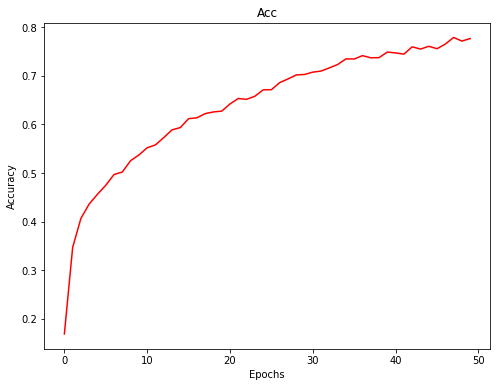

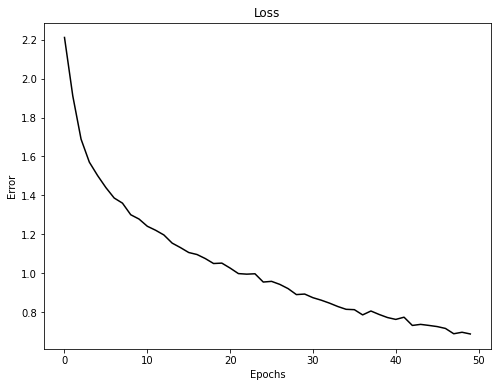

In [60]:
#@title plot results
#-----------------------------------------------------------
# Retrieve a list of list results on training data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [61]:
#@title Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

71/71 - 2s - loss: 1.0359 - accuracy: 0.6634

Test accuracy: 0.6634059548377991


In [62]:
#@title Función predict
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [64]:
#@title Ejemplo predict
predict(model, X_test[1], y_test[1])

Expected index: 1, Predicted index: [1]
